In [1]:
import BioSimSpace as BSS
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale
import glob
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import  GridSpec

import random
import numpy as np
from scipy.stats import rankdata

from itertools import chain
import os
import shutil
from functools import reduce

from rdkit import Chem
from rdkit.ML.Scoring.Scoring import CalcBEDROC, CalcROC, CalcEnrichment
from importlib import reload
plt.rcParams.update({'font.size': 16})

/home/jscheen/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 36.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jscheen/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/ipykernel_launcher.py:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [2]:
# clear everything from the LOMAP directory environment. 
# BSS/LOMAP seems to be overwriting/reusing some data when restarting the kernel.
for file in glob.glob("process/lomap/*"):
    try:
        os.remove(file)
    except IsADirectoryError:
        shutil.rmtree(file)

In [3]:
# restart kernel after changing.
exclude_intermediate = True       # excludes the intermediate ligand in the TYK2 series. 
intermediate_string = "intermediate"
fep_nn_exclude_outliers = False   # exclude outliers from FEP-NN predictions.
error_type_to_use = "input/testsets/tyk2/fep_data_tyk2_fc.csv"
tyk2_ddg_offset_file = "input/testsets/tyk2/fep_data_tyk2_fc_ddGoffset.csv"


# Analyse a single congeneric series: TYK2
## File preparation
Write a links file for all types of LOMAP input that we can generate, including LOMAP-Scores.

In [4]:
n_edges_for_networks = 25 # use this as the forced number of edges for TYK2 networks.
tyk2_fepnn_predictions_file = "output/series_predictions/tyk2_*.csv"


In [5]:
def scaleArray(arr):
    """Scales an array to be the inverse in the range [0-1]."""
    
    # normalise to the range 0-1.
    return minmax_scale(1 /  arr, feature_range=(0,1))


In [6]:
def loadFEPNNPredictions(path_to_preds, clip_fepnn_outliers):
    """Loads a set of simple CSV files containing FEPNN predictions of SEM per edge. Computes
    the ensemble mean/std. Clips outliers if specified."""
    
    fepnn_preds = []
    for input_file in glob.glob(path_to_preds):
        if "frst" in input_file:
            continue
        print(input_file)
        df = pd.read_csv(input_file) # can keep the last df as the source df because all other columns are the same.
        
        fepnn_preds.append(df["pred_sem_mean"].values)
        
    df["pred_sem_mean"] = np.mean(fepnn_preds, axis=0)
    df["pred_sem_std"] = np.std(fepnn_preds, axis=0)
    
    
    if clip_fepnn_outliers:
        print("Clipping FEPNN prediction outliers.")
        percentiles = df["pred_sem_mean"].quantile([0.01, 0.99]).values
        df["pred_sem_mean"] = np.clip(df["pred_sem_mean"], percentiles[0], percentiles[1])
    
    return df

In [7]:
def generateLinksFiles(preds_path, base_model_preds_paths, true_path, ddg_offset_path, clip_fepnn_outliers):
    """Given a csv file with SEM predictions and a csv file with true SEM values, return 
    information for links files for LOMAP.
    Because SEMs are the inverse of LOMAP (i.e. LOMAP-score 0.0 is poor, but SEM 0.0 is good), 
    we need to invert the predicted SEM values. Additionally, compress them to fall in the range 0-1 
    as is the case with LOMAP-scores."""
    true_perts = pd.read_csv(true_path)[["lig_1", "lig_2"]].values
    true_perts = [ f"{pert[0]}~{pert[1]}" for pert in true_perts]
    true_sems = pd.read_csv(true_path)["error"].values
    true_df = pd.DataFrame()
    true_df["pert_name"] = true_perts
    true_df["true_sem"] = true_sems
    
    ddG_offset_perts = pd.read_csv(ddg_offset_path)[["lig_1", "lig_2"]].values
    ddG_offset_perts = [ f"{pert[0]}~{pert[1]}" for pert in ddG_offset_perts]
    ddG_offsets = pd.read_csv(ddg_offset_path)["error"].values
    ddG_offset_df = pd.DataFrame()
    ddG_offset_df["pert_name"] = ddG_offset_perts
    ddG_offset_df["$\Delta\Delta$G$_{offset}$"] = ddG_offsets

    # load the FEP-NN predicted SEMs.
    sem_preds = [loadFEPNNPredictions(preds_path, clip_fepnn_outliers)]

    # load the base model predicted SEMs. -> SVM, RF models.
    for base_model_pred_path in glob.glob(base_model_preds_paths):
        method_name = "_".join(base_model_pred_path.split("/")[-1].split("_")[1:3]).upper()
        base_df = pd.read_csv(base_model_pred_path)
        base_df.columns = ["pert_name", method_name]
        
        # now scale the predicted SEMs to 0-1. 
        base_df[method_name] = scaleArray(base_df[method_name].values)
        sem_preds.append(base_df)
        
    # merge all the predictions together.
    preds_df = reduce(lambda  left,right: pd.merge(left,right,on=['pert_name'],
                                            how='outer'), sem_preds)
    
    # add preds and true SEMs together into one DF; replace failed true SEMs with max(SEM)
    combined_df = pd.merge(preds_df, true_df, on=["pert_name"], how="outer").fillna(max(true_sems))
    
    # add ddGoffsets to the df.
    combined_df = pd.merge(combined_df, ddG_offset_df, on=["pert_name"], how="outer").fillna(max(true_sems))    
    pert_names = combined_df["pert_name"].values
       
    # add a scaled ddGoffets to the df.
    combined_df["$\Delta\Delta$G$_{offset}$\n[0-1]"] = scaleArray(combined_df["$\Delta\Delta$G$_{offset}$"].values)
    
    # for these, take inverse and scale to 0-1.
    true_sems = scaleArray(combined_df["true_sem"].values)
    pred_sems = scaleArray(combined_df["pred_sem_mean"].values)
    random_sems = combined_df["random_sem"].values
    ecfp6_sems = combined_df["fp_similarity"].values
    
    # also get all base model arrays.
    APFP_RF = combined_df["APFP_RF"].values
    ECFP_RF = combined_df["ECFP_RF"].values
    PROPS_RF = combined_df["PROPS_RF"].values  
        
    APFP_SVR = combined_df["APFP_SVR"].values
    ECFP_SVR = combined_df["ECFP_SVR"].values
    PROPS_SVR = combined_df["PROPS_SVR"].values
    
    return pert_names, combined_df["$\Delta\Delta$G$_{offset}$\n[0-1]"].values, \
            true_sems, pred_sems, APFP_RF, ECFP_RF, PROPS_RF, APFP_SVR, ECFP_SVR, PROPS_SVR, \
            random_sems, ecfp6_sems, combined_df, combined_df[["pert_name","$\Delta\Delta$G$_{offset}$"]]
      
    
    
def writeLinksFile(pert_names, values, filename):
    with open(filename, "w") as writefile:
        writer = csv.writer(writefile, delimiter =" ")
        for pert_name, value in zip(pert_names, values):
            writer.writerow([pert_name, value])


In [8]:
# Get all values and write them to links files so that we can feed them to LOMAP.      
pert_names, ddg_offsets, true_sems, pred_sems, APFP_RF, ECFP_RF, PROPS_RF, APFP_SVR, ECFP_SVR, PROPS_SVR, \
    random_sems, ecfp6_sems, combined_df, true_df = generateLinksFiles(
                                                tyk2_fepnn_predictions_file,
                                                "output/series_predictions/base_models/tyk2_*",
                                                error_type_to_use,
                                                tyk2_ddg_offset_file,
                                                fep_nn_exclude_outliers)

writeLinksFile(pert_names, ddg_offsets, "process/lomap/lomap_inputs_ddg_offsets.csv")
writeLinksFile(pert_names, true_sems, "process/lomap/lomap_inputs_true_sems.csv")
writeLinksFile(pert_names, pred_sems, "process/lomap/lomap_inputs_pred_sems.csv")
writeLinksFile(pert_names, np.random.random_sample(len(random_sems)), "process/lomap/lomap_inputs_rand_sems.csv")
writeLinksFile(pert_names, ecfp6_sems, "process/lomap/lomap_inputs_ecfp6_sems.csv")

# base models.
writeLinksFile(pert_names, APFP_RF, "process/lomap/lomap_inputs_APFP_RF_sems.csv")
writeLinksFile(pert_names, ECFP_RF, "process/lomap/lomap_inputs_ECFP_RF_sems.csv")
writeLinksFile(pert_names, PROPS_RF, "process/lomap/lomap_inputs_PROPS_RF_sems.csv")

writeLinksFile(pert_names, APFP_SVR, "process/lomap/lomap_inputs_APFP_SVR_sems.csv")
writeLinksFile(pert_names, ECFP_SVR, "process/lomap/lomap_inputs_ECFP_SVR_sems.csv")
writeLinksFile(pert_names, PROPS_SVR, "process/lomap/lomap_inputs_PROPS_SVR_sems.csv")

output/series_predictions/tyk2_2.csv
output/series_predictions/tyk2_5.csv
output/series_predictions/tyk2_3.csv
output/series_predictions/tyk2_7.csv
output/series_predictions/tyk2_0.csv
output/series_predictions/tyk2_4.csv
output/series_predictions/tyk2_8.csv
output/series_predictions/tyk2_1.csv
output/series_predictions/tyk2_6.csv


In [9]:
# run LOMAP on the TYK2 set so that we can grab the scores.
try:
    work_dir_path = "process/lomap/lomap_workdir"
    shutil.rmtree(work_dir_path)
except FileNotFoundError:
    pass

path_to_ligands = "input/testsets/tyk2/ligands"
ligand_files = glob.glob(f"{path_to_ligands}/*.sdf")

ligands = []
ligand_names = []

for filepath in ligand_files:
    if exclude_intermediate:
        if "intermediate" in filepath:
            continue
    # append the molecule object to a list.
    ligands.append(Chem.SDMolSupplier(filepath)[0])
    
    # append the molecule name to another list so that we can use the name of each molecule in our workflow.
    ligand_names.append(filepath.split("/")[-1].replace(".sdf",""))

tranformations, lomap_scores = BSS.Align.generateNetwork(ligands, plot_network=False, names=ligand_names, 
                                                         work_dir=work_dir_path,
                                                        #n_edges_forced=n_edges_for_networks
                                                        )

In [10]:
# instead of the normal approach (see BSS tutorial), find the LOMAP score for 
# the fully-connected network in the work_dir.
lomap_perts = []
lomap_scores = []

with open("process/lomap/lomap_workdir/outputs/lomap_score_with_connection.txt", "r") as lomap_file:
    reader = csv.reader(lomap_file)
    next(reader)
    for row in reader:
        cleaned_row = [ item.replace(" ","") for item in row ]
        
        lig1 = "_".join(cleaned_row[2].split("_")[1:]).split(".")[0]
        lig2 = "_".join(cleaned_row[3].split("_")[1:]).split(".")[0]
        pert = lig1+"~"+lig2
        lomap_score = float(cleaned_row[4])
        lomap_perts.append(pert)
        lomap_scores.append(lomap_score)
        
        # lomap's mtx edges are monodirectional, but our predictions are bidirectional. Write both directions.
        inv_pert = lig2+"~"+lig1
        lomap_perts.append(inv_pert)
        lomap_scores.append(lomap_score)        
        
writeLinksFile(lomap_perts, lomap_scores, "process/lomap/lomap_inputs_lomap_scores.csv")

## Analyse SEM correlations
Plot all possible combinations of data in scatterplots, i.e. lomap, true sem, pred sem, rand sem.


In [11]:
ddg_offset_df = pd.read_csv("process/lomap/lomap_inputs_ddg_offsets.csv", names=["Perturbation", "$\Delta\Delta$G$_{offset}$\n[0-1]"], sep=" ")

true_sems_df = pd.read_csv("process/lomap/lomap_inputs_true_sems.csv", names=["Perturbation", "True SEM [0-1]"], sep=" ")
pred_sems_df = pd.read_csv("process/lomap/lomap_inputs_pred_sems.csv", names=["Perturbation", "ML-Predicted\nSEM [0-1]"], sep=" ")
rand_sems_df = pd.read_csv("process/lomap/lomap_inputs_rand_sems.csv", names=["Perturbation", "Random\nSEM [0-1]"], sep=" ")
ecfp6_sems_df = pd.read_csv("process/lomap/lomap_inputs_ecfp6_sems.csv", names=["Perturbation", "ECFP6 Tanimoto Sim."], sep=" ")

APFP_RF_df = pd.read_csv("process/lomap/lomap_inputs_APFP_RF_sems.csv", names=["Perturbation", "APFP_RF [0-1]"], sep=" ")
ECFP_RF_df = pd.read_csv("process/lomap/lomap_inputs_ECFP_RF_sems.csv", names=["Perturbation", "ECFP_RF [0-1]"], sep=" ")
PROPS_RF_df = pd.read_csv("process/lomap/lomap_inputs_PROPS_RF_sems.csv", names=["Perturbation", "PROPS_RF [0-1]"], sep=" ")
APFP_SVR_df = pd.read_csv("process/lomap/lomap_inputs_APFP_SVR_sems.csv", names=["Perturbation", "APFP_SVR [0-1]"], sep=" ")
ECFP_SVR_df = pd.read_csv("process/lomap/lomap_inputs_ECFP_SVR_sems.csv", names=["Perturbation", "ECFP_SVR [0-1]"], sep=" ")
PROPS_SVR_df = pd.read_csv("process/lomap/lomap_inputs_PROPS_SVR_sems.csv", names=["Perturbation", "PROPS_SVR [0-1]"], sep=" ")

lomap_sems_df = pd.read_csv("process/lomap/lomap_inputs_lomap_scores.csv", names=["Perturbation", "LOMAP-Score"], sep=" ")

# add the number of heavy atoms perturbed.
num_ha = combined_df[["pert_name", "num_ha_change"]]
num_ha.columns = ["Perturbation","Heavy Atoms Perturbed"]

# create a single dataframe.
sems_combined_df = reduce(lambda left,right: pd.merge(left,right,on='Perturbation'), 
      [ddg_offset_df, true_sems_df, rand_sems_df, pred_sems_df, ecfp6_sems_df, lomap_sems_df, num_ha, 
       APFP_RF_df, ECFP_RF_df, PROPS_RF_df, APFP_SVR_df, ECFP_SVR_df, PROPS_SVR_df])

# drop duplicates.
#sems_combined_df.drop_duplicates(subset="Perturbation", inplace=True)

sems_combined_df

,Perturbation,$\Delta\Delta$G$_{offset}$\n[0-1],True SEM [0-1],Random\nSEM [0-1],ML-Predicted\nSEM [0-1],ECFP6 Tanimoto Sim.,LOMAP-Score,Heavy Atoms Perturbed,APFP_RF [0-1],ECFP_RF [0-1],PROPS_RF [0-1],APFP_SVR [0-1],ECFP_SVR [0-1],PROPS_SVR [0-1]
0,lig_ejm_44~lig_ejm_49,0.005121,0.003435,0.212273,0.329764,0.777778,0.20190,6,0.096231,0.248393,0.056597,0.297491,0.322151,0.168636
1,lig_ejm_49~lig_ejm_44,0.005121,0.003435,0.279215,0.329764,0.777778,0.20190,6,0.096231,0.248393,0.056597,0.297491,0.322151,0.168636
2,lig_ejm_44~lig_ejm_55,0.128535,0.072819,0.526561,0.264375,0.819048,0.77880,4,0.396637,0.207968,0.025295,0.739134,0.314785,0.513155
3,lig_ejm_55~lig_ejm_44,0.128535,0.072819,0.478034,0.264375,0.819048,0.77880,4,0.396637,0.207968,0.025295,0.739134,0.314785,0.513155
4,lig_ejm_44~lig_jmc_28,0.004391,0.004904,0.096838,0.037712,0.781818,0.24660,6,0.368913,0.132192,0.073584,0.397256,0.200846,0.323807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,lig_ejm_42~lig_ejm_48,0.008689,0.031568,0.970539,0.227482,0.770642,0.27253,5,0.244037,0.194401,0.139469,0.432302,0.566859,0.614811
236,lig_ejm_48~lig_jmc_23,0.018331,0.027926,0.968687,0.060992,0.824561,0.04066,1,0.203520,0.002148,0.179778,0.147847,0.480948,0.372025
237,lig_jmc_23~lig_ejm_48,0.018331,0.027926,0.406903,0.060992,0.824561,0.04066,1,0.203520,0.002148,0.179778,0.147847,0.480948,0.372025
238,lig_ejm_42~lig_jmc_23,0.040008,0.088166,0.173179,0.059753,0.770642,0.30119,6,0.129881,0.002049,0.098271,0.635916,0.946528,0.279226


In [12]:
def computeStats(input_df):
    """return statistics input for table to plot."""
    col_labels = ["Random", "ECFP6", "APFP\nRF", "ECFP\nRF", "PROPS\nRF", "APFP\nSVR", "ECFP\nSVR", "PROPS\nSVR", "$\widehat{SEM}^{scaled}$", "LOMAP", "$SEM^{scaled}_{\overline{\Delta{G}}_{solvated}}$"]
    row_labels = ["Pearson r", "Mean Error", r"Kendall $\tau$"]
    table_vals = []
    for array in [input_df["Random\nSEM [0-1]"],
                  input_df["ECFP6 Tanimoto Sim."],
                  input_df["APFP_RF [0-1]"],
                  input_df["ECFP_RF [0-1]"],
                  input_df["PROPS_RF [0-1]"],
                  input_df["APFP_SVR [0-1]"],
                  input_df["ECFP_SVR [0-1]"],
                  input_df["PROPS_SVR [0-1]"],
                  input_df["ML-Predicted\nSEM [0-1]"],
                  input_df["LOMAP-Score"],
                  input_df["True SEM [0-1]"]
                 ]:
        

        r = round(stats.pearsonr(input_df["$\Delta\Delta$G$_{offset}$\n[0-1]"], array)[0], 2)
        mue = round(mean_absolute_error(input_df["$\Delta\Delta$G$_{offset}$\n[0-1]"], array), 2)
        tau = round(stats.kendalltau(input_df["$\Delta\Delta$G$_{offset}$\n[0-1]"], array)[0], 2)
        table_vals.append([r, mue, tau])
        
    # need to transpose table values to fit the row/col layout.
    table_vals = np.array(table_vals).T.tolist()
    return col_labels, row_labels, table_vals
col_labels, row_labels, table_vals = computeStats(sems_combined_df)

In [13]:
# remove intermediate
if exclude_intermediate:
    sems_combined_df = sems_combined_df[~sems_combined_df.Perturbation.str.contains(intermediate_string)]

In [14]:
sems_combined_df

,Perturbation,$\Delta\Delta$G$_{offset}$\n[0-1],True SEM [0-1],Random\nSEM [0-1],ML-Predicted\nSEM [0-1],ECFP6 Tanimoto Sim.,LOMAP-Score,Heavy Atoms Perturbed,APFP_RF [0-1],ECFP_RF [0-1],PROPS_RF [0-1],APFP_SVR [0-1],ECFP_SVR [0-1],PROPS_SVR [0-1]
0,lig_ejm_44~lig_ejm_49,0.005121,0.003435,0.212273,0.329764,0.777778,0.20190,6,0.096231,0.248393,0.056597,0.297491,0.322151,0.168636
1,lig_ejm_49~lig_ejm_44,0.005121,0.003435,0.279215,0.329764,0.777778,0.20190,6,0.096231,0.248393,0.056597,0.297491,0.322151,0.168636
2,lig_ejm_44~lig_ejm_55,0.128535,0.072819,0.526561,0.264375,0.819048,0.77880,4,0.396637,0.207968,0.025295,0.739134,0.314785,0.513155
3,lig_ejm_55~lig_ejm_44,0.128535,0.072819,0.478034,0.264375,0.819048,0.77880,4,0.396637,0.207968,0.025295,0.739134,0.314785,0.513155
4,lig_ejm_44~lig_jmc_28,0.004391,0.004904,0.096838,0.037712,0.781818,0.24660,6,0.368913,0.132192,0.073584,0.397256,0.200846,0.323807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,lig_ejm_42~lig_ejm_48,0.008689,0.031568,0.970539,0.227482,0.770642,0.27253,5,0.244037,0.194401,0.139469,0.432302,0.566859,0.614811
236,lig_ejm_48~lig_jmc_23,0.018331,0.027926,0.968687,0.060992,0.824561,0.04066,1,0.203520,0.002148,0.179778,0.147847,0.480948,0.372025
237,lig_jmc_23~lig_ejm_48,0.018331,0.027926,0.406903,0.060992,0.824561,0.04066,1,0.203520,0.002148,0.179778,0.147847,0.480948,0.372025
238,lig_ejm_42~lig_jmc_23,0.040008,0.088166,0.173179,0.059753,0.770642,0.30119,6,0.129881,0.002049,0.098271,0.635916,0.946528,0.279226


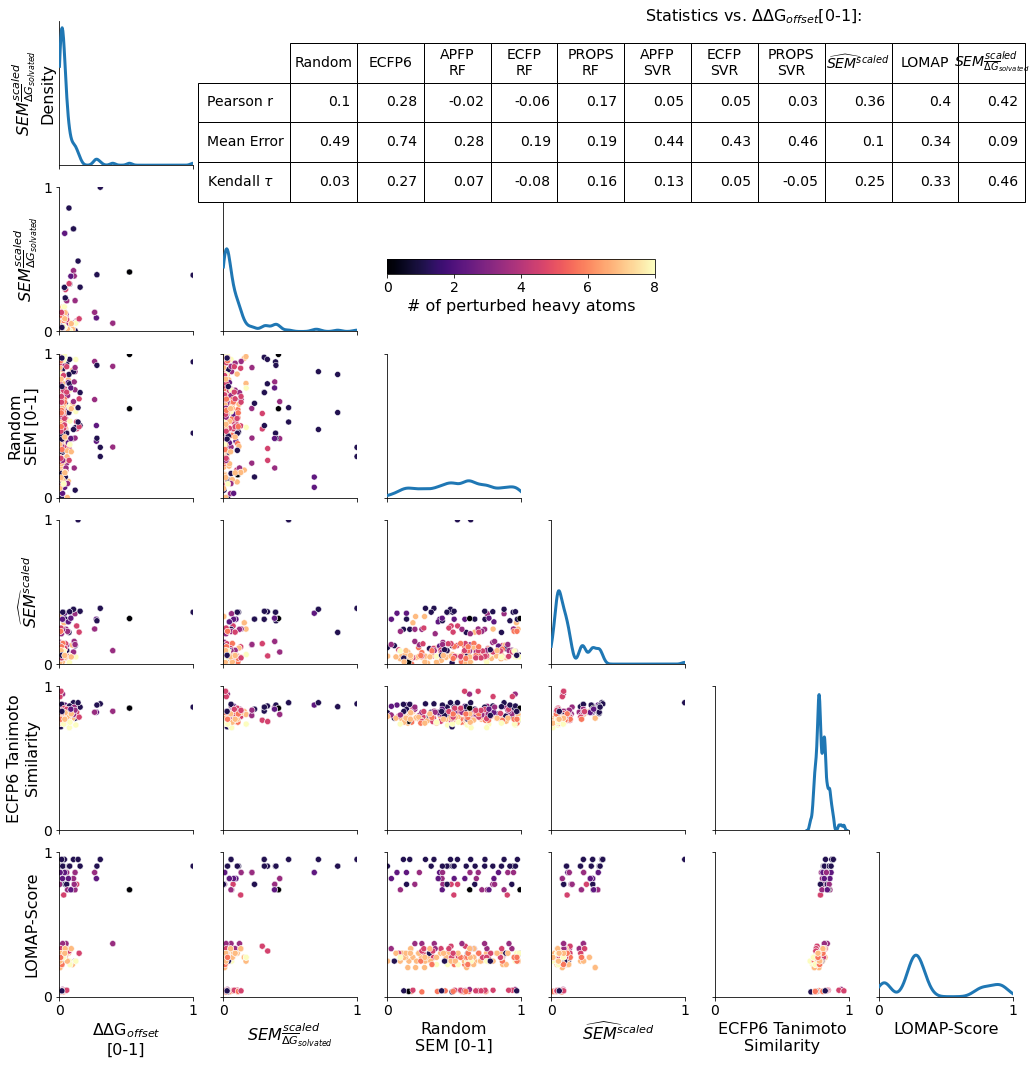

In [15]:
data = sems_combined_df.iloc[:, : 8] # don't plot the base_models correlations, only include them in table.

# make a pairplot.
new_column_names = ['Perturbation', '$\Delta\Delta$G$_{offset}$\n[0-1]', '$SEM^{scaled}_{\overline{\Delta{G}}_{solvated}}$', 'Random\nSEM [0-1]',
       '$\widehat{SEM}^{scaled}$', 'ECFP6 Tanimoto\nSimilarity', 'LOMAP-Score',
       'Heavy Atoms Perturbed']
data.columns = new_column_names
g = sns.PairGrid(data, hue="Heavy Atoms Perturbed", palette='magma')
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3, hue=None, bw_adjust=0.5, clip=(0.0, 1.0))

# $SEM^{scaled}_{\overline{\Delta{G}}_{solvated}}$
# $\widehat{SEM}^{scaled}$

# create the colorbar.
norm = plt.Normalize(data["Heavy Atoms Perturbed"].min(), data["Heavy Atoms Perturbed"].max()+1)
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
sm.set_array([])

axins = inset_axes(g.axes.flatten()[8],
                   width="200%",  # width = 5% of parent_bbox width
                   height="10%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0.0, 0.4, 1, 1),
                   bbox_transform=g.axes.flatten()[8].transAxes,
                   borderpad=0,
                   )

cbar = g.figure.colorbar(sm, shrink=1.5, cax=axins, orientation="horizontal")
cbar.set_label('# of perturbed heavy atoms')


# hide empty graphs.
for i, ax in enumerate(g.axes.flatten()):
    if i in [1, 2, 3, 4, 5, 8, 9, 10, 11, 15, 16, 17, 22, 23, 29]:
        ax.axis("off")
        

#adjust ticks such that each plot just shows 0 and 1.
for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(plt.MaxNLocator(1))
    ax.yaxis.set_major_locator(plt.MaxNLocator(1))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    
    
# Hide y ticks in true SEM density plot to avoid confusion.
g.axes.flatten()[0].set_yticks([])
g.axes.flatten()[0].set_ylabel("$SEM^{scaled}_{\overline{\Delta{G}}_{solvated}}$\nDensity")


# create a table with statistics.
table = g.axes.flatten()[7].table(cellText=table_vals,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  bbox=[0.5, 0.9, 5.5, 1.1], zorder=100)
table.auto_set_font_size(False)
table.set_fontsize(14)


g.axes.flatten()[3].annotate("Statistics vs. $\Delta\Delta$G$_{offset}$[0-1]:",xy=(0.7,1))

plt.savefig("/home/jscheen/projects/FEPSPACE/figures/pairplot_sem_predictions.png", dpi=300)


plt.show()

Note: this figure was not used in analysis as transforming all arrays to [0-1] and then doing statistical analysis skews results.

## Network generation and analysis
Generate networks with links_files. Run a LOMAP function for each. Compute Sum of SEMs for each.

In [16]:
def runLOMAP(links_file, n_edges_for_networks):
    """
    For a given links file, runs LOMAP using the edge scorings specified in the file. Returns
    information on the generated network (edges, ligand names etc). Broadly speaking, this function
    uses a working directory for LOMAP to run in, then parses some of the files that LOMAP outputs.
    """
    runner_work_dir = "process/lomap/lomap_runner_workdir/"
    if os.path.exists(runner_work_dir):
        shutil.rmtree(runner_work_dir)
        
    # run LOMAP on the set so that we can grab the scores.
    path_to_ligands = "input/testsets/tyk2/ligands"
    ligand_files = glob.glob(f"{path_to_ligands}/*.sdf")

    ligands = []
    ligand_names = []

    for filepath in ligand_files:
        if exclude_intermediate:
            if "intermediate" in filepath: # remove intermediate from network generation.
                continue
            
        # append the molecule object to a list.
        ligands.append(Chem.SDMolSupplier(filepath)[0])

        # append the molecule name to another list so that we can use the name of each molecule in our workflow.
        ligand_names.append(filepath.split("/")[-1].replace(".sdf",""))

    # bit of a workaround, but we have to find the SDF file names that LOMAP uses internally.  
    # write out a second linksfile that doesn't have the tilde to denote the perturbations. Also
    # use glob in the pre-generated LOMAP work folder to find what we should call our ligands (i.e.
    # refer to the internal LOMAP file name).
    links_file_contents = pd.read_csv(links_file, sep=" ", header=None)
    lomap_internal_files = glob.glob("process/lomap/lomap_workdir/inputs/*.sdf")
    internal_links_file_path = links_file.replace(".csv", "_internal.csv")

    with open(internal_links_file_path, "w") as writefile:
        writer = csv.writer(writefile, delimiter =" ")
              
        for pert_name, value in zip(links_file_contents[0].values, links_file_contents[1].values):
            if exclude_intermediate:
                if "intermediate" in pert_name:
                    continue
                    
            # find the internal path.
            for lig in lomap_internal_files:
                if pert_name.split("~")[0] in lig:
                    lig1 = lig.split("/")[-1].replace(".sdf.sdf",".sdf")
                elif pert_name.split("~")[1] in lig:
                    lig2 = lig.split("/")[-1].replace(".sdf.sdf",".sdf") 
                              
            writer.writerow([lig1, lig2, value])
    
    
    # now run LOMAP with the pre-specified edge scorings.
    tranformations, lomap_scores = BSS.Align.generateNetwork(ligands, plot_network=False, names=ligand_names,
                                                            links_file=internal_links_file_path,
                                                            #work_dir=runner_work_dir,
                                                            #n_edges_forced=n_edges_for_networks
                                                            )
    
    pert_network_dict = {}
    transformations_named = [(ligand_names[transf[0]], ligand_names[transf[1]]) for transf in tranformations]
    for transf, score in zip(transformations_named, lomap_scores):
        transf_tilde = "~".join(transf)
        pert_network_dict[transf_tilde] = score
    
    return tranformations, lomap_scores, pert_network_dict

In [17]:
def calcTrueSEMS(pert_network_dict, true_sems_df, true_sem_input=False):
    """Given a specific combination of edges, computes the True SEMs in the network."""
    true_sems_per_edge = []
    perts = []
    for pert, v in pert_network_dict.items():
        if true_sem_input:
            # in case we are dealing with True SEM input to LOMAP, the pert_network_dict will
            # already contain true SEMs as scores. return these instead of parsing the reference DF. 
            sem_this_pert = v
        else:
            # from the dataframe with true sems, find the true sem for this edge that LOMAP has suggested.
            try:
                sem_this_pert = true_sems_df[true_sems_df["Perturbation"] == pert]["$\Delta\Delta$G$_{offset}$"].values[0]
            except IndexError:
                inv_pert = f"{pert.split('~')[1]}~{pert.split('~')[0]}"
                sem_this_pert = true_sems_df[true_sems_df["Perturbation"] == inv_pert]["$\Delta\Delta$G$_{offset}$"].values[0]

        true_sems_per_edge.append(sem_this_pert)
        perts.append(pert)

    
    return true_sems_per_edge, len(true_sems_per_edge), perts

In [18]:
_, lomap_scores_random, pert_network_dict_random = runLOMAP("process/lomap/lomap_inputs_rand_sems.csv", n_edges_for_networks)
_, lomap_scores_pred, pert_network_dict_pred = runLOMAP("process/lomap/lomap_inputs_pred_sems.csv", n_edges_for_networks)
_, lomap_scores_lomap, pert_network_dict_lomap = runLOMAP("process/lomap/lomap_inputs_lomap_scores.csv", n_edges_for_networks)
_, lomap_scores_ecfp6, pert_network_dict_ecfp6 = runLOMAP("process/lomap/lomap_inputs_ecfp6_sems.csv", n_edges_for_networks)
_, lomap_scores_true_sem, pert_network_dict_true_sem = runLOMAP("process/lomap/lomap_inputs_true_sems.csv", n_edges_for_networks)
_, lomap_scores_ddg_offset, pert_network_dict_ddg_offset = runLOMAP("process/lomap/lomap_inputs_ddg_offsets.csv", n_edges_for_networks)

_, lomap_scores_APFP_RF, pert_network_dict_APFP_RF= runLOMAP("process/lomap/lomap_inputs_APFP_RF_sems.csv", n_edges_for_networks)
_, lomap_scores_ECFP_RF, pert_network_dict_ECFP_RF = runLOMAP("process/lomap/lomap_inputs_ECFP_RF_sems.csv", n_edges_for_networks)
_, lomap_scores_PROPS_RF, pert_network_dict_PROPS_RF = runLOMAP("process/lomap/lomap_inputs_PROPS_RF_sems.csv", n_edges_for_networks)

_, lomap_scores_APFP_SVR, pert_network_dict_APFP_SVR= runLOMAP("process/lomap/lomap_inputs_APFP_SVR_sems.csv", n_edges_for_networks)
_, lomap_scores_ECFP_SVR, pert_network_dict_ECFP_SVR = runLOMAP("process/lomap/lomap_inputs_ECFP_SVR_sems.csv", n_edges_for_networks)
_, lomap_scores_PROPS_SVR, pert_network_dict_PROPS_SVR = runLOMAP("process/lomap/lomap_inputs_PROPS_SVR_sems.csv", n_edges_for_networks)

In [19]:
print("Number of edges in networks using inputs:")
print("RANDOM", len(pert_network_dict_random))
print("ECFP6 TANIMOTO", len(pert_network_dict_ecfp6))
print("$\widehat{SEM}^{scaled}$", len(pert_network_dict_pred))
print("LOMAP-Score", len(pert_network_dict_lomap))
print("$SEM^{scaled}_{\overline{\Delta{G}}_{solvated}}$", len(pert_network_dict_true_sem))
print("$\Delta\Delta$G$_{offset}$", len(pert_network_dict_ddg_offset))

print("\nBase models:")
print("APFP_RF", len(pert_network_dict_APFP_RF))
print("ECFP_RF", len(pert_network_dict_ECFP_RF))
print("PROPS_RF", len(pert_network_dict_PROPS_RF))
print("APFP_SVR", len(pert_network_dict_APFP_SVR))
print("ECFP_SVR", len(pert_network_dict_ECFP_SVR))
print("PROPS_SVR", len(pert_network_dict_PROPS_SVR))

Number of edges in networks using inputs:
RANDOM 20
ECFP6 TANIMOTO 23
$\widehat{SEM}^{scaled}$ 27
LOMAP-Score 23
$SEM^{scaled}_{\overline{\Delta{G}}_{solvated}}$ 24
$\Delta\Delta$G$_{offset}$ 22

Base models:
APFP_RF 21
ECFP_RF 22
PROPS_RF 22
APFP_SVR 29
ECFP_SVR 28
PROPS_SVR 22


In [20]:
def toPandasSeaborn(input_sems, input_perts, scoring_type):
    """ Transform the input data to include information for plotting boxplots.
    Bit annoying to have to switch to pandas again to accommodate seaborn's api.."""
    input_df = pd.DataFrame(input_sems)
    input_df.columns = ["SEM"]
    input_df["SCORING_TYPE"] = scoring_type
    input_df["PERT"] = input_perts
    
    return input_df

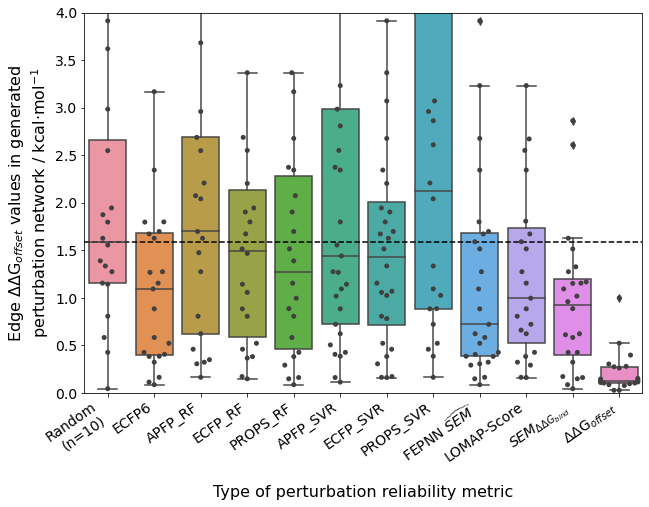

In [21]:
original_true_sems_df = true_df[["pert_name", "$\Delta\Delta$G$_{offset}$"]]
original_true_sems_df.columns = ["Perturbation", "$\Delta\Delta$G$_{offset}$"]

# for random, repeat n times with random scores to reduce the chance of an accidentally decent network as 
# we have a low number of ligands in this series.
true_sems_random_repeated = []
for _ in range(10):
    for k, v in pert_network_dict_random.items():
        pert_network_dict_random[k] = random.random()
    true_sems_random, num_edges_random, perts_random = calcTrueSEMS(pert_network_dict_random, original_true_sems_df)
    true_sems_random_repeated.append(true_sems_random)
    
# get the mean true sem per pert for these random replicates.
true_sems_random = np.mean(true_sems_random_repeated, axis=0)

## the remaining types we can just do a single time (as they'll be the same each repeat).
true_sems_pred, num_edges_pred, perts_pred = calcTrueSEMS(pert_network_dict_pred, original_true_sems_df)
true_sems_lomap, num_edges_lomap, perts_lomap = calcTrueSEMS(pert_network_dict_lomap, original_true_sems_df)
true_sems_ecfp6, num_edges_ecfp6, perts_ecfp6 = calcTrueSEMS(pert_network_dict_ecfp6, original_true_sems_df)
true_sems_true, num_edges_true, perts_true = calcTrueSEMS(pert_network_dict_true_sem, original_true_sems_df)
true_sems_ddg_offset, num_edges_ddg_offset, perts_ddg_offset = calcTrueSEMS(pert_network_dict_ddg_offset, original_true_sems_df,
                                                         true_sem_input=True)




true_sems_APFP_RF, num_edges_APFP_RF, perts_APFP_RF = calcTrueSEMS(pert_network_dict_APFP_RF, original_true_sems_df)
true_sems_ECFP_RF, num_edges_ECFP_RF, perts_ECFP_RF = calcTrueSEMS(pert_network_dict_ECFP_RF, original_true_sems_df)
true_sems_PROPS_RF, num_edges_PROPS_RF, perts_PROPS_RF = calcTrueSEMS(pert_network_dict_PROPS_RF, original_true_sems_df)
true_sems_APFP_SVR, num_edges_APFP_SVR, perts_APFP_SVR = calcTrueSEMS(pert_network_dict_APFP_SVR, original_true_sems_df)
true_sems_ECFP_SVR, num_edges_ECFP_SVR, perts_ECFP_SVR = calcTrueSEMS(pert_network_dict_ECFP_SVR, original_true_sems_df)
true_sems_PROPS_SVR, num_edges_PROPS_SVR, perts_PROPS_SVR = calcTrueSEMS(pert_network_dict_PROPS_SVR, original_true_sems_df)

input_sems_list = [true_sems_random, true_sems_ecfp6, true_sems_APFP_RF, true_sems_ECFP_RF, true_sems_PROPS_RF, true_sems_APFP_SVR, true_sems_ECFP_SVR, true_sems_PROPS_SVR, true_sems_pred, true_sems_lomap, true_sems_true, true_sems_ddg_offset]
input_perts_list = [perts_random, perts_ecfp6, perts_APFP_RF, perts_ECFP_RF, perts_PROPS_RF, perts_APFP_SVR, perts_ECFP_SVR, perts_PROPS_SVR, perts_pred, perts_lomap, perts_true, perts_ddg_offset]
scoring_types_list = ["Random\n(n=10)", "ECFP6", "APFP_RF", "ECFP_RF", "PROPS_RF", "APFP_SVR", "ECFP_SVR", "PROPS_SVR", "FEPNN $\widehat{SEM}$", "LOMAP-Score", "$SEM_{\Delta\Delta{G}_{bind}}$", "$\Delta\Delta$G$_{offset}$"]

plotting_dfs = []
for input_sems, input_perts, scoring_type in zip(input_sems_list, input_perts_list, scoring_types_list):
    plotting_dfs.append(toPandasSeaborn(input_sems, input_perts, scoring_type))

concat_df = pd.concat(plotting_dfs, ignore_index=True)


plt.figure(figsize=(10,7))
ax = sns.boxplot(x="SCORING_TYPE", y="SEM", data=concat_df)
ax = sns.swarmplot(x="SCORING_TYPE", y="SEM", data=concat_df, color=".25")



plt.xlabel("Type of perturbation reliability metric", labelpad=20)
plt.xticks(rotation=35, ha='right') 
plt.ylabel("Edge $\Delta\Delta$G$_{offset}$ values in generated\nperturbation network / kcal$\cdot$mol$^{-1}$")
plt.ylim(0, 4)
plt.axhline(np.median(true_sems_random), ls="--", color="black")

plt.savefig("/home/jscheen/projects/FEPSPACE/figures/boxplots_tyk2_edges_sems.png", dpi=300, bbox_inches = "tight")

plt.show()

## Analyse Free Energies vs. Expt per generated network

For all the generated networks, let freenrgworkflows compute ddGs per ligand. Compare this to experimental
binding affinities. See e.g. https://github.com/michellab/BioSimSpaceTutorials/blob/main/04_fep/analyse_fep.ipynb for a guide on using this code.

In [22]:
# import from path (github clone) as a conda install is not available yet for freenrgworkflows.
import sys
sys.path.insert(1, '../../../BioSimSpaceTutorials/04_fep/freenrgworkflows/networkanalysis/')
import networkanalysis as networkanalysis_few
import experiments as experiments_few
import stats as stats_few

In [23]:
def getTrueSEMs(perturbations, work_path):
    """Given a list of perturbations that contain SEM values, retrieve the True SEM per perturbation and
    write to a file such that it can be used by FreeNrgWorkflows to estimate ddGs."""
    fep_freenrgs_and_sems = pd.read_csv(work_path)
    
    
    missing_counter = 0
    with open("process/lomap/freenrgworkflows_input.csv", "w") as writefile:
        writer = csv.writer(writefile)
        for pert in perturbations:
            try:
                # for each pert, find the true freenrg and SEM and generate a summary file for freenrgworkflows.
                lig_1, lig_2 = pert.split("~")
                lig_1_rows = fep_freenrgs_and_sems[fep_freenrgs_and_sems["lig_1"] == lig_1]
                lig_12_row = lig_1_rows[lig_1_rows["lig_2"] == lig_2]
                write_data = lig_12_row.values[0].tolist()

            except IndexError:
                # perturbation SEM not found -> simulation will have failed for this. 
                # Instead, set freenrg to be 5000 and error to be max(SEM)
                write_data = [lig_1, lig_2, 5000, max(fep_freenrgs_and_sems['error'])]
                missing_counter += 1
            writer.writerow(write_data)

        # also write the inverse perturbation.
        for pert in perturbations:
            try:
                lig_2, lig_1 = pert.split("~")
                lig_1_rows = fep_freenrgs_and_sems[fep_freenrgs_and_sems["lig_1"] == lig_1]
                lig_12_row = lig_1_rows[lig_1_rows["lig_2"] == lig_2]
                write_data = lig_12_row.values[0].tolist()
            except IndexError:
                # perturbation SEM not found -> simulation will have failed for this. 
                # Instead, set freenrg to be 5000 and error to be max(SEM)
                write_data = [lig_1, lig_2, 5000, max(fep_freenrgs_and_sems['error'])]
            
            writer.writerow(write_data)

    return "process/lomap/freenrgworkflows_input.csv", missing_counter


In [24]:
def computeRelativeDDGs(input_path):
    """Uses FreeNrgWorkFlows to estimate per-ligand DDGs based on the provided network edge freenrgs and errors."""
    nA = networkanalysis_few.NetworkAnalyser()
    nA.read_perturbations_pandas(input_path, comments='#')

    computed_relative_DDGs = nA.freeEnergyInKcal
    
    return computed_relative_DDGs

In [25]:
def computeExptDDGs(expt_path, data_type):
    """Uses FreeNrgWorkFlows to estimate experimental per-ligand DDGs based on 
    the provided network edge freenrgs and errors."""
        
    experiments_obj = experiments_few.ExperimentalData()

    experiments_obj.compute_affinities(expt_path, data_type=data_type, comments="#", delimiter=",")
    experimental_DDGs = experiments_obj.freeEnergiesInKcal
    
    return experimental_DDGs

In [26]:
def getFreenrgDict(computed_relative_DDGs, experimental_DDGs):
    """Merges together FEP and experimental DDG predictions for easier analysis."""
    freenrg_dict = {}

    # construct dict with experimental freenrg and error.
    for item in experimental_DDGs:
        ligand = list(item.keys())[0]
        if intermediate_string not in ligand:
            freenrg = list(item.values())[0]
            error = list(item.values())[1]
            freenrg_dict[ligand] = [freenrg, error]

    # append computed freenrg and error.
    for item in computed_relative_DDGs:
            ligand = list(item.keys())[0]
            freenrg = list(item.values())[0]
            error = list(item.values())[1]

            if intermediate_string not in ligand:
                freenrg_dict[ligand].append(freenrg)
                freenrg_dict[ligand].append(error)
    
    try:
        freenrg_df = pd.DataFrame(freenrg_dict, index=["freenrg_exp", "err_exp", "freenrg_fep", "err_fep"]).transpose()
    except ValueError:
        raise ValueError("Ligand missing from network - likely disconnected from graph because of edge forcing.")
        
    return freenrg_df

In [27]:
def plotBounds(ax):
    # plot 1/2 kcal bounds:
    ax.fill_between(
                    x=[-100, 100], 
                    y2=[-100.25,99.75],
                    y1=[-99.75, 100.25],
                    lw=0, 
                    zorder=-2,
                    alpha=0.3,
                    color="grey")
    # upper bound:
    ax.fill_between(
                    x=[-100, 100], 
                    y2=[-99.5,100.5],
                    y1=[-99.75, 100.25],
                    lw=0, 
                    zorder=-2,
                    color="grey", 
                    alpha=0.2)
    # lower bound:
    ax.fill_between(
                    x=[-100, 100], 
                    y2=[-100.25,99.75],
                    y1=[-100.5, 99.5],
                    lw=0, 
                    zorder=-2,
                    color="grey", 
                    alpha=0.2)

In [28]:
def plotPredictions(freenrg_df, computed_relative_DDGs,experimental_DDGs, title, n_perts, ax, num_failed_edges=False, is_base=False):
    """Plots a scatterplot of FEP vs EXP as well as a table of statistics."""
    
    if title == "$\widehat{SEM}^{scaled}$":
        c_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
                   
        c = [ c_cycle[1] if i < -2 else c_cycle[0] for i in freenrg_df["freenrg_fep"].values]
        ax.scatter(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], zorder=3, c=c)
    else:
        ax.scatter(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], zorder=3)
        
    ax.set_xticks([-2, 0, 2])
    ax.set_yticks([-2, 0, 2])
    
    
    stats_to_return = []

    # plot error bars:
    yerr = freenrg_df["err_fep"]
    xerr = freenrg_df["err_exp"]
    if not is_base:
        ax.errorbar(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], 
                    yerr=yerr,
                    xerr=xerr,   # comment this line to hide experimental error bars \
                                 # as this can sometimes overcrowd the plot.
                    ls="none",
                    lw=0.5, 
                    capsize=2,
                    color="black",
                    zorder=2
                    )


    # get the bounds. This can be done with min/max or simply by hand.
    all_freenrg_values = np.concatenate([freenrg_df["freenrg_exp"].values,freenrg_df["freenrg_fep"].values])

    # for a scatterplot we want the axis ranges to be the same. 
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-3.5, 3.5)

    # format the plot further.
    ax.set_axisbelow(True)
    ax.axhline(color="grey", zorder=1, alpha=0.2)
    ax.axvline(color="grey", zorder=1, alpha=0.2)
    
    _stats = stats_few.freeEnergyStats()
    _stats.generate_statistics(computed_relative_DDGs,experimental_DDGs,repeats=10000)
    r_confidence = _stats.R_confidence
    tau_confidence = _stats.tau_confidence
    mue_confidence = _stats.mue_confidence
    
    #ax.annotate(f"n edges: {n_perts}", xy=(0.05, 0.9), xycoords='axes fraction')
    stats_to_return.append([r_confidence[1], r_confidence[0], r_confidence[2]])
    stats_to_return.append([mue_confidence[1], mue_confidence[0], mue_confidence[2]])
    stats_to_return.append([tau_confidence[1], tau_confidence[0], tau_confidence[2]])
    
    if num_failed_edges:
        ax.annotate(num_failed_edges, xy=(0.9, 0.05), color='red', fontsize=25,xycoords='axes fraction')
    #ax.set_title(title)
    ax.grid(False)
    
    return stats_to_return

In [29]:
def computePM(stats_triplet):
    """For a list of three values where the middle value is the mean and the outer values are the outer bounds,
    return the mean and the plus-minus as the mean error of the bounds compared to the mean."""
    mean_val = stats_triplet[1]
    error_1 = mean_val - stats_triplet[0]
    error_2 = stats_triplet[2] - mean_val 
    mean_err = np.mean([error_1, error_2])
    
    return round(mean_val, 2), round(mean_err, 2)

In [30]:
def getRandomNetwork():
    """Generates a random network using random SEMs."""
    # write a new links file first. 
    writeLinksFile(pert_names, np.random.random_sample(len(random_sems)), "process/lomap/lomap_inputs_rand_sems.csv")
    
    # get the selected perts.
    _, _, pert_network_dict_random = runLOMAP("process/lomap/lomap_inputs_rand_sems.csv", n_edges_for_networks)
    _, _, perts_random = calcTrueSEMS(pert_network_dict_random, original_true_sems_df)
    
    return perts_random

In [33]:
def plotNetworkStats():
    grid = GridSpec(6, 2,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.13, hspace=0.25)

    fig = plt.figure(figsize=(8, 24))

    ax1 = fig.add_subplot(grid[0, 0])
    ax2 = fig.add_subplot(grid[0, 1])
    ax3 = fig.add_subplot(grid[1, 0])
    ax4 = fig.add_subplot(grid[1, 1])
    ax5 = fig.add_subplot(grid[2, 0])
    ax6 = fig.add_subplot(grid[2, 1])


    pred_collections = [perts_random, perts_PROPS_RF, perts_ecfp6, perts_pred, 
                        perts_lomap, perts_ddg_offset]
    pred_types = ["RANDOM", "RF_TOP", "ECFP6","RBFENN\n$\widehat{SEM}$", 
                  "LOMAP-\nScore", 
                  "$\Delta\Delta$G$_{offset}$"]        

    
    returned_stats_coll = []
    for perts, title, ax in zip(pred_collections, pred_types, [ax1,
                                                                    ax2,
                                                                    ax3,
                                                                    ax4,
                                                                    ax5,
                                                                    ax6
                                                                    ]):
        print(title)
        n_perts = len(perts)  
        
        if title == "RANDOM":
            # in case of RANDOM, we want to repeat 10x to show that even though sometimes random networks
            # are OK, across 10x the variance is high and the average is poor.
            r_bucket = []
            mue_bucket = []
            tau_bucket = []
            for i in range(10):
                print(i)
                perts = getRandomNetwork()
                freenrgworkflows_input_path, num_failed_edges = getTrueSEMs(perts, error_type_to_use)

                # use FEW to estimate per-ligand DDGs for both FEP and EXPT
                computed_relative_DDGs = computeRelativeDDGs(freenrgworkflows_input_path)
                experimental_DDGs = computeExptDDGs("input/testsets/tyk2/exp_data_tyk2.dat", "IC50")
                os.remove(freenrgworkflows_input_path)

                # Get statistics for this replicate.
                freenrg_df = getFreenrgDict(computed_relative_DDGs, experimental_DDGs)
                ax.cla() # clears the plot such that we don't overlap scatters for this plot.
                returned_stats = plotPredictions(freenrg_df, computed_relative_DDGs, experimental_DDGs, title, n_perts, ax, num_failed_edges)
                returned_stats = [computePM(stats) for stats in returned_stats]
                # add stats to buckets.
                r_bucket.append(returned_stats[0][0])
                mue_bucket.append(returned_stats[1][0])
                tau_bucket.append(returned_stats[2][0])
            # compute mean and std over random replicates, return in standard format (see below in else).
            stats_to_return = [(np.mean(r_bucket), np.std(r_bucket)), 
                              (np.mean(mue_bucket), np.std(mue_bucket)),
                              (np.mean(tau_bucket), np.std(tau_bucket))]
            returned_stats_coll.append(stats_to_return)
            
        
        else:  
            # do the standard routine just 1x.
            # get the true SEMs for all the used edges for this protocol.     

            freenrgworkflows_input_path, num_failed_edges = getTrueSEMs(perts, error_type_to_use)

            # use FEW to estimate per-ligand DDGs for both FEP and EXPT
            computed_relative_DDGs = computeRelativeDDGs(freenrgworkflows_input_path)
            experimental_DDGs = computeExptDDGs("input/testsets/tyk2/exp_data_tyk2.dat", "IC50")
            os.remove(freenrgworkflows_input_path)

            # Plot this protocol into a subplot.
            freenrg_df = getFreenrgDict(computed_relative_DDGs, experimental_DDGs)
            returned_stats = plotPredictions(freenrg_df, computed_relative_DDGs, experimental_DDGs, title, n_perts, ax, num_failed_edges)

            returned_stats = [computePM(stats) for stats in returned_stats]
            returned_stats_coll.append(returned_stats)




    # plot statistics on the bottom plot.
    seaborn_data = [["Input", "Metric", "Value", "+/-"]]
    for method, __stats in zip(pred_types, returned_stats_coll):
        st_types = ["Pearson R", "MUE / kcal$\cdot$mol$^{-1}$", r"Kendall $\tau$"]
        for st, typ in zip(__stats, st_types):
            seaborn_data.append([method, typ, st[0], st[1]])

    seaborn_data_df = pd.DataFrame(seaborn_data[1:],columns=seaborn_data[0])
    seaborn_data_df_r = seaborn_data_df[seaborn_data_df['Metric'] == 'Pearson R']
    seaborn_data_df_tau = seaborn_data_df[seaborn_data_df['Metric'] == r"Kendall $\tau$"]
    seaborn_data_df_mue = seaborn_data_df[seaborn_data_df['Metric'] == 'MUE / kcal$\cdot$mol$^{-1}$']

    #### left barplot
    seaborn_data_left = pd.concat([seaborn_data_df_r, seaborn_data_df_tau])

    ax7 = fig.add_subplot(grid[3, 0])
    ax_tr = sns.barplot(x="Metric", y="Value", hue="Input", 
                        data=seaborn_data_left, ax=ax7)
    ax_tr.set_ylim(0, 1)

    x_coords = [p.get_x() + 0.5*p.get_width() for p in ax_tr.patches]
    y_coords = [p.get_height() for p in ax_tr.patches]
    ax_tr.errorbar(x=x_coords, y=y_coords, yerr=seaborn_data_left["+/-"].sort_index(), fmt="none", c= "k")

    #### right barplot
    seaborn_data_right = seaborn_data_df_mue

    ax8 = fig.add_subplot(grid[3, 1])
    ax_tr = sns.barplot(x="Metric", y="Value", hue="Input", 
                        data=seaborn_data_right, ax=ax8)
    ax_tr.set_ylim(0.2, 2.5)

    x_coords = [p.get_x() + 0.5*p.get_width() for p in ax_tr.patches]
    y_coords = [p.get_height() for p in ax_tr.patches]
    ax_tr.errorbar(x=x_coords, y=y_coords, yerr=seaborn_data_right["+/-"], fmt="none", c= "k")


    # remove title from legend and format it to fit nicely in the right barplot. 
    handles, labels = ax8.get_legend_handles_labels()

#     leg1 = plt.legend(handles[:2], labels[:2], bbox_to_anchor=[0.15,0.6], loc='lower left', framealpha=1)
    leg2 = plt.legend(handles, labels, 
#                       bbox_to_anchor=[0.45,0.32], 
                      loc='upper right', 
                      framealpha=1, 
                      ncol=2,
                      handletextpad=0.1,
                      fontsize=11
                     )

#     leg1.get_frame().set_linewidth(0.0)
#     leg2.get_frame().set_linewidth(0.0)

#     plt.gca().add_artist(leg1)
    plt.gca().add_artist(leg2)

    #ax8.legend(handles=handles[0:], labels=labels[0:],fontsize='small', bbox_to_anchor=(1, 1))
    # ax8.legend(handles=handles[0:], labels=labels[0:],fontsize=11,
    #            ncol=2,
    #            #handleheight=2.4, 
    #            #labelspacing=0.005
    #           )

    # remove legend from left bar plot
    ax7.legend([],[], frameon=False)

    # reformat axis labels for barplots.
    ax7.set_ylabel("Metric value")
    ax7.set_xlabel("")
    ax8.set_ylabel("")
    ax8.set_xlabel("")
       

    ## some final layout touches on the whole plot.
    ax3.set_ylabel("Predicted $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
    ax5.set_xlabel("Experimental $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$", ha='left')
    plt.tight_layout()

    # set subplot enumeration.
    indexing = ["A", "B", "C", "D", "E", "F", "G", "H"]
    titles = []
    for i, (ax, title) in enumerate(zip([ax1, ax2, ax3, ax4, ax5, ax6], pred_types)):
        ax.annotate(indexing[i], xy=(0.01, 0.9), xycoords="axes fraction", size="x-large")
        ax.annotate(title, xy=(0.25, 0.8), xycoords="axes fraction", ha="center")
        
        plotBounds(ax) # add confidence bounds.

    ax7.annotate(indexing[6], xy=(0.01, 0.9), xycoords="axes fraction", size="x-large")
    ax8.annotate(indexing[7], xy=(0.01, 0.9), xycoords="axes fraction", size="x-large")

    # set horizontal grid lines in barplots.
    ax7.set_axisbelow(True)
    ax7.yaxis.grid(color='gray', linestyle='dashed')
    ax8.set_axisbelow(True)
    ax8.yaxis.grid(color='gray', linestyle='dashed')   



    plt.savefig("/home/jscheen/projects/FEPSPACE/figures/tyk2_ddg_predictions.png", dpi=300)

        

    plt.show()

RANDOM
0
1
2
3
4
5
6
7
8
9
RF_TOP
ECFP6
RBFENN
$\widehat{SEM}$
LOMAP-
Score
$\Delta\Delta$G$_{offset}$


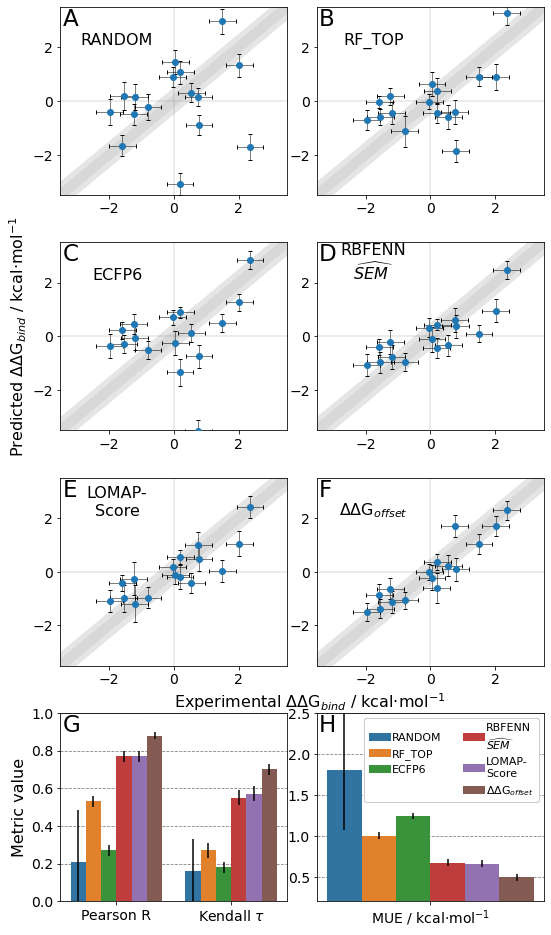

In [34]:
plotNetworkStats()

### Check FEP networks for FEPNN and LOMAP-Score

In [ ]:
def plotNetwork(links_file):
    path_to_ligands = "input/testsets/tyk2/ligands"
    ligand_files = glob.glob(f"{path_to_ligands}/*.sdf")

    runner_work_dir = "tmp/lomap"
    if os.path.exists(runner_work_dir):
        shutil.rmtree(runner_work_dir)


    ligands = []
    ligand_names = []

    for filepath in ligand_files:

        # append the molecule object to a list.
        ligands.append(Chem.SDMolSupplier(filepath)[0])

        # append the molecule name to another list so that we can use the name of each molecule in our workflow.
        ligand_names.append(filepath.split("/")[-1].replace(".sdf",""))

    transformations, lomap_scores = BSS.Align.generateNetwork(ligands, plot_network=True, names=ligand_names, 
                                                             links_file=links_file
                                                            )
    return ligand_names, transformations

In [ ]:
# plot naive LOMAP network
ligand_names, transformations_lomap = plotNetwork("process/lomap/lomap_inputs_lomap_scores_internal.csv")

In [ ]:
# plot FEPNN network
ligand_names, transformations_fepnn = plotNetwork("process/lomap/lomap_inputs_pred_sems_internal.csv")

In [ ]:
# ddGoffset (positive control) network
_, _ = plotNetwork("process/lomap/lomap_inputs_ddg_offsets_internal.csv")

In [ ]:
# random (negative control) network
_, _ = plotNetwork("process/lomap/lomap_inputs_rand_sems_internal.csv")

In [ ]:
def computeNetworkOverlap(transformations_lomap, transformations_fepnn):
    overlap = 0

    for edge_lomap in transformations_lomap:
        
        inv_edge = (edge_lomap[1], edge_lomap[0])
        if edge_lomap in transformations_fepnn:

            overlap += 1
        elif inv_edge in transformations_fepnn:
            overlap += 1


    if overlap == 0:
        perc_overlap = 0
    else:
        perc_overlap_lomap = int(overlap/len(transformations_lomap)*100)
        perc_overlap_fepnn = int(overlap/len(transformations_fepnn)*100)
        perc_overlap = np.mean([perc_overlap_lomap, perc_overlap_fepnn])

    return len(transformations_lomap), int(perc_overlap), len(transformations_fepnn)

In [ ]:
# get overlapping edges between fepnn and lomap networks.

print(computeNetworkOverlap(transformations_lomap, transformations_fepnn))


for i, j in transformations_fepnn:
    if (i,j) in transformations_lomap or (j,i) in transformations_lomap:
        print(f"{ligand_names[i]}~{ligand_names[j]}")